In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from qiskit import IBMQ, BasicAer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_state_qsphere
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor

from qiskit.tools.visualization import plot_histogram
from IPython.display import display, Math, Latex

## The Deutsch-Jozsa Algorithm

The Deutsch-Jozsa Algorithm is a deterministic quantum algorithm proposed by David Deutsch and Richard Jozsa in 1992, it is one of the first algorithms to show a improvement over the classical computing solution for a given problem. The algorithm consists of a function $f:\{0, 1\}^n \rightarrow \{0, 1\}$ that takes n-digit binary values as input and produces either a 0 or a 1 as output for each such value. We are promised that the fuction is either balanced or constant, i.e, a function is called balanced if exactly half of its inputs give us an output equal to *0* and the other half equals *1*, otherwise it is constant if all outputs are equal 0 or all outputs equals *1*. Therefore, we will define a oracle based on $f$ to decide if a given function is either constant or balanced.

Even though the algorithm does not has a important application on real life it show us in a very simple way of how quantum computing can improve our classical computers algorithm solutions. 

$$
\begin{align*}
Constant:\ & f(0, 0) = 1 && f(0, 1) = 1  && f(1, 0) = 1 && f(1, 1) = 1 \\
Constant:\ & f(0, 0) = 0 && f(0, 1) = 0  && f(1, 0) = 0 && f(1, 1) = 0 \\
Balanced:\ & f(0, 0) = 1 && f(0, 1) = 0  && f(1, 0) = 1 && f(1, 1) = 0 \\
Balanced:\ & f(0, 0) = 0 && f(0, 1) = 1  && f(1, 0) = 0 && f(1, 1) = 1 
\end{align*}
$$

### Applying Hadamard Gates on Qubits

As we already have discussed on previous articles in more detail, quantum computing works on the computational basis $|0\rangle$ and $|1\rangle$ using Quantum Mechanical Phenomena as superposition and entanglement to create efficient problem solutions. And we do that by applying linear unitary transformations on quantum states.

One of the most important gates in Quantum Computing is the Hadarmad Gate $H$, a recursevely constructed matrix of order $2^n$.

$$
\begin{align*}
H_0 = \begin{bmatrix}
                       1
                       \end{bmatrix} \qquad
H_1 = \frac{1}{\sqrt{2}} \begin{bmatrix}
                       1 & 1\\
                       1 & -1
                       \end{bmatrix} \qquad 
H_n = \frac{1}{\sqrt{2^n}} \begin{bmatrix}
                       H_{n-1} & H_{n-1}\\
                       H_{n-1} & -H_{n-1}
                       \end{bmatrix}
\end{align*}
$$

State_0  |x> =  [1.+0.j 0.+0.j]
State_1 H|x> =  [0.70710678+0.j 0.70710678+0.j]


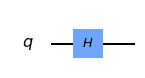

In [2]:
#define a 1 qubit state |0>
sv = Statevector.from_label('0')
print('State_0  |x> = ', sv.data)

#build a circuit with the H gate
mycircuit = QuantumCircuit(1)
mycircuit.h(0)

#apply the circuit into |x>
sv = sv.evolve(mycircuit)


print('State_1 H|x> = ', sv.data)
mycircuit.draw('mpl')

Which can be used to put a state $|\psi\rangle$ in superposition, i.e, to take a state from the computational basis to the $|+\rangle$ and $|-\rangle$ basis, where we have $\frac{1}{2}$ probability of measuring $|1\rangle$ and $\frac{1}{2}$ of measuring $|0\rangle$. And we define the operation of applying a Hadarmard gate into a quantum state as it follows. 

$$
\begin{align*}
\\H|0\rangle = \frac{1}{\sqrt{2}} \begin{bmatrix}
                                   1 & 1\\
                                   1 & -1
                                \end{bmatrix} 
                                %
             \begin{bmatrix}
             1 \\
             0
             \end{bmatrix}
             =
             \frac{|0\rangle + |1\rangle}{\sqrt{2}}
             =
             |+\rangle
\\\\H|1\rangle = \frac{1}{\sqrt{2}} \begin{bmatrix}
                                   1 & 1\\
                                   1 & -1
                                \end{bmatrix} 
                                %
             \begin{bmatrix}
             0 \\
             1
             \end{bmatrix}
             =
             \frac{|0\rangle - |1\rangle}{\sqrt{2}}
             =
             |-\rangle
\end{align*}\\
$$

Which can be generally seen for an arbitrary state on n-qubits $|x\rangle$ as

$$
\begin{align*}
H|x\rangle &= \frac{1}{\sqrt{2^n}}\sum_{k \in \{0, 1\}^n}(-1)^{\langle x, k\rangle}|k\rangle
\end{align*}
$$

Another gates that will be used to build our algorithm are the the pauli-X gate $X$ and its multi-qubit controlled version the $CNOT$ gate, but you can find more information about these gates and others single and multi qubit gates in the [Introduction](https://github.com/matheusmtta/Quantum-Computing/blob/master/Introduction.ipynb) notebook.

## The Algorithm

Classicaly to answer the question proposed for our problem in a n-size input we would need at most $2^{n-1}+1$, queries to check if our fuction is either constant or balanced, because since we are promised that it will always be one of them, we need to check our input set till we find a different outcome from the previous ones or check exactly half of our input set and one more to be sure if it is balanced or constant, which give us a $\mathcal{O}(n)$ solution.

While with the quantum approach we need only one query! Which give us a $\mathcal{O}(1)$ solution! And this is accomplished by using the following circuit. 

<img src="images/dj_circuit.png" style="width:500px; height:160"/>

The circuit works with $n+1$ qubits where first $n$ qubits $|x\rangle$ are initialized as $|0\rangle$ and the last $|y\rangle$ is an ancilla qubit initialized as $|1\rangle$ used as a target phase kick-back qubit in $Uf$. After putting all qubits in superpostion by applying the Hadarmard gates, $Uf$ is applied as $|x\rangle|y\rangle \rightarrow |x\rangle|y \oplus f(x)\rangle$, where $\oplus$ is the sum$\%2$ of $y$ and $f(x)$, but for the purpose of our explanation lets ignore this last qubit for a while. Finally we apply the Hadarmard gates on $|x\rangle$ and measure the state.

And from that we claim, **if our measured output is the zero $|0...0\rangle$ bitstring our function $f$ is constant, otherwise $f$ is balanced**. 

To demonstrate that, we will check it step by step and see explicitly what is happening ir our algorithm circuit.

**Step 0.** First we initialize all of ours $n$ qubits at the $|0\rangle$ state.
$$
\begin{align*}
|\psi_0\rangle = |0\rangle^{\otimes n}
\end{align*}
$$

**Step 1.** Then we apply the Hadamard gates to put them on superposition. 
$$
\begin{align*}
|\psi_1\rangle = H^{\otimes n}|\psi_0\rangle = \frac{1}{\sqrt{2^n}}\sum_{x \in \{0, 1\}^n}(-1)^{x \psi_0}|x\rangle
\end{align*}
$$

**Step 2.** After that we apply the $Uf$ gate that will work as phase operator given by $f(x)$, it will be explained in details later.
$$
\begin{align*}
|\psi_2\rangle = Uf|\psi_1\rangle & = \frac{1}{\sqrt{2^n}}\sum_{x \in \{0, 1\}^n}(-1)^{x\psi_0}Uf|x\rangle\\
                                  & = \frac{1}{\sqrt{2^n}}\sum_{x \in \{0, 1\}^n}(-1)^{f(x)}|x\rangle\\
\end{align*}
$$

**Step 3.** Finally we just apply the Hadamard gates again

$$
\begin{align*}
|\psi_3\rangle = H^{\otimes n}|\psi_2\rangle & = \frac{1}{\sqrt{2^n}}\sum_{x \in \{0, 1\}^n}(-1)^{f(x)}H^{\otimes n}|x\rangle\\
                                             & = \frac{1}{2^n}\sum_{x \in \{0, 1\}^n}(-1)^{f(x)}\sum_{k \in \{0, 1\}^n}(-1)^{kx}|k\rangle\\
                                             & = \sum_{k \in \{0, 1\}^n}\bigg{[}\frac{1}{2^n}\sum_{x \in \{0, 1\}^n} (-1)^{f(x) + kx}\bigg{]}|k\rangle
\end{align*}
$$

Now the last step consists into measure the $n$ qubits and see what is the amplitude associated with the all zeros states $|0...0\rangle$ and check if our claim holds. So in order to clean up our state $|\psi_3\rangle$ equation lets define

$$
    a_k = \frac{1}{2^n}\sum_{x \in \{0, 1\}^n} (-1)^{f(x) + kx}
$$

**Step 4.**

$$
\begin{align*}
    P(|000...0\rangle) &= |\langle 000...0| \psi_3\rangle |^2\\
                       &= \bigg{|}\sum_{k \in \{0, 1\}^n} a_k\langle 000...0| k\rangle \bigg{|}^2 \quad \text{since  } \langle 000...0| k\rangle = \begin{cases} 1, & \mbox{if } k = |000...0\rangle \\ 0, & \mbox{otherwise (orthogonal)} \end{cases}\\
                       &= |a_{|000...0\rangle}|^2\\
                       &= \bigg{|}\frac{1}{2^n}\sum_{x \in \{0, 1\}^n} (-1)^{f(x)}\bigg{|}^2 \quad \text{since $k = 0$ all factors $kx$ vanishes.}\\
                       &= \begin{cases} 1, & \mbox{if } f(x) = 0 \quad \forall x \in \{0, 1\}^n \\ 1, & \mbox{if } f(x) = 1 \quad \forall x \in \{0, 1\}^n \\ 0, & \mbox{if it is balanced} \end{cases}\\
\end{align*}
$$

Hence, if our function is constant we will measure the state $|000...0\rangle$ with one hundred percent of certainty, while if it is balanced we will measure any other state among $\{0, 1\}^n$ besides the all zeros one, exactly as we wanted to demonstrate.

## Implementation

Now that we understood theoretically the DJ Algorihm, to implement the algorithm protocol we need to see how exactly $Uf$ works in our state $|x\rangle|y\rangle \rightarrow |x\rangle|y \oplus f(x)\rangle$. In order to do it, lets create a small example that will explain how the phase $(-1)^{f(x)}$ is applied in our state. Let $f:\{0,1\}^2 \rightarrow \{0, 1\}$ such that

$$
    f(0, 0) = 0\\
    f(0, 1) = 1\\
    f(1, 0) = 1\\
    f(0, 0) = 0
$$

We know that this is a balanced function, since it is a pretty small example, but the algorithm still blinded for it.

We will remake the steps from the explanation above, but now using the $|1\rangle$ ancilla qubit. 

**Step 0** Initialize n qubits at the $|0\rangle$ state and one last qubit at the $|1\rangle$ state.
$$
\begin{align*}
    |\psi_0\rangle & =  |00\rangle|1\rangle
\end{align*}
$$

**Step 2** Apply The Hadarmard Gates
$$
\begin{align*}
    |\psi_1\rangle & =  H^{\otimes 2}|00\rangle H|1\rangle\\
                   & = |+\rangle^{\otimes 2}|-\rangle\\
                   & = \bigg(\frac{|0\rangle + |1\rangle}{\sqrt{2}}\bigg)\bigg(\frac{|0\rangle + |1\rangle}{\sqrt{2}}\bigg)\bigg(\frac{|0\rangle - |1\rangle}{\sqrt{2}}\bigg)\\
                   & = \frac{1}{2}\bigg(|00\rangle + |01\rangle + |10\rangle + |11\rangle\bigg)\bigg(\frac{|0\rangle - |1\rangle}{\sqrt{2}}\bigg)
\end{align*}
$$

**Step 3** Now that we have our state in superposition we will apply the $Uf$ gate

$$
\begin{align*}
|\psi_2\rangle & = \frac{1}{2}\bigg(|00\rangle + |01\rangle + |10\rangle + |11\rangle\bigg)U_f\bigg(\bigg(\frac{|0\rangle - |1\rangle}{\sqrt{2}}\bigg)\bigg)\\
               & = \frac{1}{2\sqrt{2}} \sum_{x \in \{0, 1\}^2} |x\rangle \bigg(|0 \oplus f(x)\rangle - |1 \oplus f(x)\rangle\bigg)\\
               & = \frac{1}{2\sqrt{2}}\bigg[|00\rangle \bigg(|0\rangle - |1\rangle\bigg) - |01\rangle \bigg(|0\rangle - |1\rangle\bigg) - |10\rangle \bigg(|0\rangle - |1\rangle\bigg) + |11\rangle \bigg(|0\rangle - |1\rangle\bigg)\bigg]
\end{align*}
$$

We can see the phase kick-back occurring on the two middle states $|01\rangle$ and $|10\rangle$, where our $|y\rangle$ after applying $Uf$ kicked a $-1$ phase to outside, i.e, when $f(x) = 1$ the $|x\rangle$ state will be multiplied by a phase $-1$. Therefore, to see explicitly, let f(x) = 1.

$$
\begin{align*}
    |x\rangle Uf|y\rangle &= |x\rangle \bigg(|0 \oplus 1\rangle - |1 \oplus 1\rangle\bigg{)}\\
                          &= |x\rangle \bigg(|0 \oplus 1\rangle - |1 \oplus 1\rangle\bigg{)}\\
                          &= |x\rangle \bigg(|1\rangle - |0\rangle\bigg{)}\\
                          &= -|x\rangle |-\rangle
\end{align*}
$$

Now as we did at the explanation above we will ignore the last Qubit and evaluate our circuit only by the first **n** Qubits.

$$
  |\psi_2\rangle = \frac{1}{2}\bigg[|00\rangle - |01\rangle - |10\rangle + |11\rangle\bigg]
$$

Then remain to us only to apply the Hadamard Gate on this state to get our result, in order to make it simpler we will use the matrix notation of the Hadamard $H^{\otimes 2}$ to get the computation result.

$$
\begin{align*}
    |\psi_3\rangle & =  H^{\otimes 2}|\psi_2\rangle\\ 
                & = \begin{bmatrix}
                      1 & 1 & 1 & 1\\
                      1 & -1 & 1 & -1\\
                      1 & 1 & -1 & -1\\
                      1 & -1 & -1 & 1
                      \end{bmatrix}%
                      \frac{1}{2}
                      %
                     \begin{bmatrix}
                      1\\
                      -1\\
                      -1\\
                      1
                      \end{bmatrix}\\
                 & = |11\rangle
\end{align*}
$$

Hence, as we expected we have got an outcome $|11\rangle$ which means that the function is balanced.

Finally, now that we see clearly how the $Uf$ function works marking the $x_i$ elements such that $f(x_i) = 1$, and we can implement this using Qiskit.

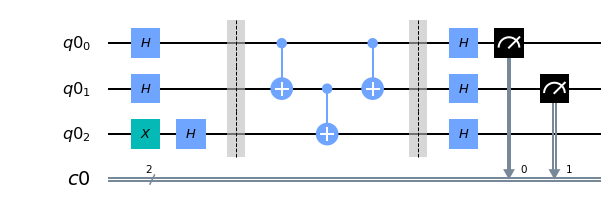

In [3]:
'''
OUR FUNCTION F IS DEFINED AS
                n = 2
                f(0, 0) = 0
                f(0, 1) = 1
                f(1, 0) = 1
                f(1, 1) = 1
'''
#input size
n = 2

#initialize qubits and measurement bits
input_qubits = QuantumRegister(n+1)
output_bits = ClassicalRegister(n)

#create circuit
my_circuit = QuantumCircuit(input_qubits, output_bits)

#apply X on the last qubit
my_circuit.x(n)

#apply Hadamard on all qubits
my_circuit.h(range(n+1))

my_circuit.barrier()

#Apply Uf, these CNOT gates will mark the desired |x_i>
my_circuit.cx(0, 1)
my_circuit.cx(1, 2)
my_circuit.cx(0, 1)

my_circuit.barrier()

#apply Hadamard on all qubits
my_circuit.h(range(n+1))

my_circuit.measure(range(n), range(n))


#Backend classical simulation
backend = BasicAer.get_backend('qasm_simulator')
atp = 1024
res = execute(my_circuit, backend=backend, shots=atp).result()
ans = res.get_counts()
my_circuit.draw(output='mpl')

#Quantum Backend
#SOON#

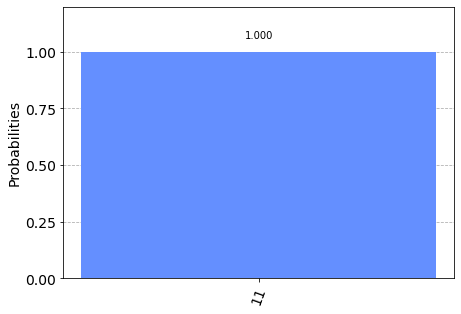

In [4]:
plot_histogram(ans)

In [5]:
from qiskit import IBMQ
IBMQ.load_account()

provider = IBMQ.get_provider(group='open', project='main')
backend = provider.get_backend('ibmq_vigo')
job = execute(my_circuit, backend=backend)
result = job.result().get_counts()

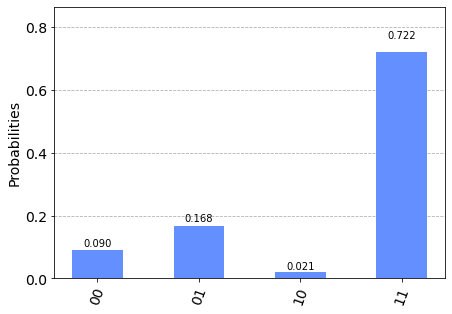

In [6]:
plot_histogram(result)